In [1]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install opencv-python
# !pip install torchsummary
# !pip list

In [2]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
0
NVIDIA GeForce RTX 3070


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from matplotlib.pyplot import imread
import cv2
import numpy as np
import random
import numpy.random as rng
from sklearn.cluster import DBSCAN
from torchsummary import summary
import scipy.stats as stats
from tqdm import tqdm  # Import tqdm function from the tqdm module

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
#====================================================================================
#                   Loading images and family names
#====================================================================================
def loadimgs(path,w,h,n_shot):
    X = []
    y = []
    cat_dict = {}
    lang_dict = {}
    fam_dict = {}
    curr_y = 0
    idx = 0
    for fam in sorted(os.listdir(path)):
        fam_path = os.path.join(path,fam)
        if fam == '1_avg' or fam == '1_known' or fam == 'SINGLETON' or len(os.listdir(fam_path)) < n_shot:
            continue

        lang_dict[fam] = [curr_y,None]
        category_images=[]
        fam_dict[idx] = fam
        idx += 1
        for img in os.listdir(fam_path):
            image_path = os.path.join(fam_path, img)
            if os.path.isdir(image_path):
                continue
            cat_dict[curr_y] = (fam, img)
            img = imread(image_path)[:,:,:3]
            img_resized = cv2.resize(img,(w,h))
            category_images.append(img_resized)
            #print(image_path+', '+str(img_resized.shape))
            lang_dict[fam][1] = curr_y
            curr_y += 1
        X.append(category_images)
        y.append(curr_y)
            
    y = np.vstack(y)

    print('[Info] Classes: '+str(len(lang_dict)))
    print('[Info] Images: '+str(y[-1][0]))
    
    return X,y,lang_dict,fam_dict


In [5]:
import torch
import random

def generate_pairs(support_imgs, n_shot, n_way, device, hard_negatives_info=None, hard_positives_info=None):
    # Calculate the number of positive and negative pairs needed
    total_pairs_per_class = n_shot * (n_shot - 1) // 2
    total_positive_pairs = total_pairs_per_class * n_way

    # Pre-allocate tensors for efficiency
    left_images_tensor = torch.empty(total_positive_pairs * 2, *support_imgs.size()[1:], device=device)
    right_images_tensor = torch.empty(total_positive_pairs * 2, *support_imgs.size()[1:], device=device)
    labels_tensor = torch.empty(total_positive_pairs * 2, device=device)

    # Generate positive and negative pairs
    pair_idx = 0
    for class_idx in range(n_way):
        class_images = support_imgs[class_idx * n_shot:(class_idx + 1) * n_shot]
        for i in range(n_shot):
            for j in range(i + 1, n_shot):
                left_images_tensor[pair_idx] = class_images[i]
                right_images_tensor[pair_idx] = class_images[j]
                labels_tensor[pair_idx] = 1.0  # Positive pair
                pair_idx += 1

                # For each positive pair, add a corresponding negative pair
                negative_class_idx = random.choice([x for x in range(n_way) if x != class_idx])
                negative_image = support_imgs[negative_class_idx * n_shot + random.randint(0, n_shot - 1)]

                left_images_tensor[pair_idx] = class_images[i]
                right_images_tensor[pair_idx] = negative_image
                labels_tensor[pair_idx] = 0.0  # Negative pair
                pair_idx += 1

    # Shuffle the pairs to mix positive and negative pairs
    indices = torch.randperm(pair_idx, device=device)
    left_images_tensor = left_images_tensor[indices]
    right_images_tensor = right_images_tensor[indices]
    labels_tensor = labels_tensor[indices]

    return left_images_tensor, right_images_tensor, labels_tensor

In [6]:
import numpy as np
import torch
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

def get_prototypes(z, n_shot, n_class, percentile=20):
    prototypes = {class_idx: [] for class_idx in range(n_class)}

    for i in range(n_class):
        # Extract embeddings for the current class
        support_set = z[i * n_shot:(i + 1) * n_shot]

        # Check if support_set is a numpy array and on CPU, if not convert
        if not isinstance(support_set, np.ndarray):
            support_set_np = support_set.cpu().detach().numpy()
        else:
            support_set_np = support_set

        # Calculate pairwise distances and determine dynamic epsilon
        distances = pdist(support_set_np)
        eps = np.percentile(distances, percentile)

        # Ensure epsilon is greater than 0
        eps = max(eps, 0.001)  # Set a minimum threshold for eps to avoid InvalidParameterError

        # Perform DBSCAN clustering on support embeddings (a single class)
        clustering = DBSCAN(eps=eps, min_samples=1).fit(support_set_np)

        # Calculate cluster centroids as prototypes
        unique_clusters = np.unique(clustering.labels_)
        for cluster_id in unique_clusters:
            if cluster_id == -1:  # Skip noise points
                continue

            cluster_indices = np.where(clustering.labels_ == cluster_id)[0]
            cluster_embeddings = support_set[cluster_indices]

            # Calculate the mean of embeddings within the same cluster to form a prototype
            if len(cluster_embeddings) > 0:
                cluster_center = torch.mean(cluster_embeddings.clone().detach(), dim=0)
                prototypes[i].append(cluster_center)

        # Additionally, calculate the overall prototype for the class
        if len(support_set) > 0:
            overall_prototype = torch.mean(support_set.clone().detach(), dim=0)
            prototypes[i].append(overall_prototype)

    return prototypes


In [7]:
class EpisodeLoader:
    def __init__(self, X, y, class_info, n_way, k_shot, q_queries):
        self.X = X
        self.y = y
        self.class_info = class_info
        self.n_way = n_way
        self.k_shot = k_shot
        self.q_queries = q_queries
        self.class_frequency = {class_idx: 0 for class_idx in range(len(X))}  # Tracking frequency
        self.class_accuracy = {class_idx: {'correct': 0, 'total': 0} for class_idx in range(len(X))}

    def load_episode(self):
        # Calculate weights for each class based on inverse frequency
        max_freq = max(self.class_frequency.values())
        weights = [(max_freq - self.class_frequency[class_idx]) + 1 for class_idx in range(len(self.X))]
        
        # Normalize weights to sum to 1
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

        # Sample n_way classes based on the calculated weights
        sampled_classes = np.random.choice(range(len(self.X)), size=self.n_way, replace=False, p=weights)
        
        support_set = []
        support_labels = []
        query_set = []
        query_labels = []

        # Increment frequency count for each sampled class
        for class_idx in sampled_classes:
            self.class_frequency[class_idx] += 1
            
        # Remap labels to range from 0 to n_way-1
        remapped_labels = {class_idx: i for i, class_idx in enumerate(sampled_classes)}

        for class_idx in sampled_classes:
            # Get all available images in the class
            available_images = self.X[class_idx]

            # If there are not enough images, use available images as both support and query
            if len(available_images) < self.k_shot + self.q_queries:
                repeated_images = available_images * ((self.k_shot + self.q_queries) // len(available_images) + 1)
                sampled_images = random.sample(repeated_images, self.k_shot + self.q_queries)
            else:
                # Randomly sample k_shot + q_queries images from the class
                sampled_images = random.sample(available_images, self.k_shot + self.q_queries)

            # Split into support and query sets
            support_set.extend(sampled_images[:self.k_shot])
            support_labels.extend([remapped_labels[class_idx]] * self.k_shot)  # Remapped label
            query_set.extend(sampled_images[self.k_shot:])
            query_labels.extend([remapped_labels[class_idx]] * self.q_queries)  # Remapped label

        # Convert to torch tensors and normalize
        support_set = torch.stack([torch.tensor(img).permute(2, 0, 1).float() for img in support_set])
        query_set = torch.stack([torch.tensor(img).permute(2, 0, 1).float() for img in query_set])
        
        # Create a mapping from remapped labels to original class labels
        remap_dict = {remapped_label: actual_label for remapped_label, actual_label in enumerate(sampled_classes)}
        
        # Keep track of actual labels of the query set for accuracy calculation
        actual_query_labels = [class_idx for class_idx in sampled_classes for _ in range(self.q_queries)]

    
        return support_set, torch.tensor(support_labels), query_set, torch.tensor(query_labels), actual_query_labels, remap_dict
    
    def get_class_accuracy(self):
        return {class_idx: round(info['correct'].item() / info['total'], 3) if info['total'] > 0 else 0 for class_idx, info in self.class_accuracy.items()}
        #return self.class_accuracy
    
    def update_class_accuracy(self, predictions, actual_targets):
        for actual_class in set(actual_targets):
            # Get the indices of actual targets that match the current class
            target_indices = [i for i, target in enumerate(actual_targets) if target == actual_class]
    
            # Count how many times the predicted class matches the actual class at these indices
            correct_count = sum(predictions[i] == actual_class for i in target_indices)
    
            # Update the class accuracy tracking
            self.class_accuracy[actual_class.item()]['correct'] += correct_count
            self.class_accuracy[actual_class.item()]['total'] += len(target_indices)
            
    def get_class_frequency(self):
        # Sort the class_frequency dictionary by frequency counts in descending order
        sorted_frequency = {k: v for k, v in sorted(self.class_frequency.items(), key=lambda item: item[1], reverse=True)}
        return sorted_frequency

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)
    
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, label, reduction='mean'):
        # Euclidean distance between embeddings
        distance = F.pairwise_distance(embedding1, embedding2, keepdim=False)  # keepdim=False for 1D tensor
 
        # Contrastive loss calculation
        losses = (label * torch.pow(distance, 2) +
                  (1 - label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        
        if reduction == 'none':
            return losses
        elif reduction == 'mean':
            return torch.mean(losses)
        elif reduction == 'sum':
            return torch.sum(losses)
        else:
            raise ValueError(f"Unsupported reduction '{reduction}'. Use 'none', 'mean', or 'sum'.")

class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        attention_map = self.conv1(x)
        attention_map = attention_map.view(x.size(0), -1) # Flatten the spatial dimensions
        attention_map = self.softmax(attention_map)
        attention_map = attention_map.view(x.size(0), 1, x.size(2), x.size(3)) # Reshape back to image dimensions
        return x * attention_map

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Use a shared MLP
        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels // ratio, in_channels, 1, bias=False),
            nn.Dropout(0.2)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = self.shared_MLP(self.avg_pool(x))
        maxout = self.shared_MLP(self.max_pool(x))
        return self.sigmoid(avgout + maxout)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avgout = torch.mean(x, dim=1, keepdim=True)
        maxout, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avgout, maxout], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class SiameseCNN(nn.Module):
    def __init__(self, encoder):
        super(SiameseCNN, self).__init__()
        self.encoder = encoder
        self.channel_attention = ChannelAttention(in_channels=128)
        self.spatial_attention = SpatialAttention()
        
        print("Encoder Parameters:", count_parameters(encoder))
        print("Channel Attention Parameters:", count_parameters(self.channel_attention))
        print("Spatial Attention Parameters:", count_parameters(self.spatial_attention))

    def forward(self, input1, input2, return_attention_maps=False):
        # Compute embeddings for both inputs
        emb1 = self.encoder(input1)
        emb2 = self.encoder(input2)
        
        # Apply Channel Attention
        ca1 = self.channel_attention(emb1) * emb1
        ca2 = self.channel_attention(emb2) * emb2

        # Apply Spatial Attention
        sa1 = self.spatial_attention(ca1) * ca1
        sa2 = self.spatial_attention(ca2) * ca2
        
        if return_attention_maps:
            return emb1, emb2, ca1, ca2, sa1, sa2
        
        # Flatten embeddings after applying attention
        emb1 = sa1.view(sa1.size(0), -1)  # Flatten
        emb2 = sa2.view(sa2.size(0), -1)  # Flatten
        
        return emb1, emb2

def load_single_siamese(**kwargs):
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']
    
    
    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    
    encoder = nn.Sequential(
        conv_block(x_dim[0], hid_dim),
        conv_block(hid_dim, hid_dim),
        conv_block(hid_dim, hid_dim),
        conv_block(hid_dim, z_dim)
    )
    # summary(encoder.to(device), input_size=x_dim)
    
    return SiameseCNN(encoder)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_image_embedding(model, image, device='cpu'):
    # Move the model to the specified device
    model.to(device)

    # If the input image is not already a batch, add a batch dimension [B, C, H, W] where B=1
    if len(image.shape) == 3:
        image = image.unsqueeze(0)

    # Move the image to the specified device
    image = image.to(device)

    # Disable gradient computation for inference
    with torch.no_grad():
        embedding = model.encoder(image)
        # Apply the attention mechanism to the embedding
        embedding = model.channel_attention(embedding) * embedding
        embedding = model.spatial_attention(embedding) * embedding
        # Flatten the output to get a vector representation      
        embedding = embedding.view(embedding.size(0), -1)  # Flatten
        embedding = normalize_embeddings(embedding)
    return embedding

def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

def flatten_and_calculate_distances(zq, prototypes_dict):
    # Flatten all prototypes into a single tensor
    all_prototypes = []
    for class_idx, class_prototypes in prototypes_dict.items():
        all_prototypes.extend(class_prototypes)  # Assuming class_prototypes is already a list of tensors
    
    # Stack all prototypes into a single tensor
    all_prototypes_tensor = torch.stack(all_prototypes)
    
    # Calculate Euclidean distances between each query sample and each prototype
    dists = euclidean_dist(zq, all_prototypes_tensor)
    
    return dists

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(original_image, attention_map):
    # Upsample attention map to match the original image size
    upsampled_attention = F.interpolate(attention_map.unsqueeze(0), size=original_image.shape[-2:], mode='bilinear', align_corners=False)
    # Take the mean of the attention maps across the channel dimension
    aggregated_attention = torch.mean(upsampled_attention, dim=1).squeeze(0)

    # Normalize the aggregated attention map for better visualization
    aggregated_attention = (aggregated_attention - aggregated_attention.min()) / (aggregated_attention.max() - aggregated_attention.min())

    # Convert to numpy arrays for plotting
    original_image_np = original_image.cpu().detach().numpy()
    aggregated_attention_np = aggregated_attention.cpu().detach().numpy()

    # Plot original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(original_image_np, (1, 2, 0)))  # Adjust this if needed
    plt.title("Original Image")
    plt.axis('off')

    # Plot attention map
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(original_image_np, (1, 2, 0)), alpha=0.5)  # Adjust this if needed
    plt.imshow(aggregated_attention_np, cmap='jet', alpha=0.5)
    plt.title("Attention Overlay")
    plt.axis('off')

    plt.show()

In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_pair(original_image1, attention_map1, original_image2, attention_map2):
    # Function to upsample and normalize attention map
    def process_attention(original_image, attention_map):
        upsampled_attention = F.interpolate(attention_map.unsqueeze(0), size=original_image.shape[-2:], mode='bilinear', align_corners=False)
        aggregated_attention = torch.mean(upsampled_attention, dim=1).squeeze(0)
        aggregated_attention = (aggregated_attention - aggregated_attention.min()) / (aggregated_attention.max() - aggregated_attention.min())
        return aggregated_attention.cpu().detach().numpy()
    
    # Process both attention maps
    aggregated_attention_np1 = process_attention(original_image1, attention_map1)
    aggregated_attention_np2 = process_attention(original_image2, attention_map2)
    
    # Convert original images to numpy arrays for plotting
    original_image_np1 = original_image1.cpu().detach().permute(1, 2, 0).numpy()
    original_image_np2 = original_image2.cpu().detach().permute(1, 2, 0).numpy()

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(6, 6))  # 4 subplots: 2 original images and 2 with attention overlay
    
    axes[0].imshow(original_image_np1)
    axes[0].axis('on')
    axes[0].tick_params(left=False, bottom=False)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(original_image_np2)
    axes[1].axis('on')
    axes[1].tick_params(left=False, bottom=False)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    axes[2].imshow(original_image_np1, alpha=0.7)
    axes[2].imshow(aggregated_attention_np1, cmap='jet', alpha=0.3)
    axes[2].axis('on')
    axes[2].tick_params(left=False, bottom=False)
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    axes[3].imshow(original_image_np2, alpha=0.7)
    axes[3].imshow(aggregated_attention_np2, cmap='jet', alpha=0.3)
    axes[3].axis('on')
    axes[3].tick_params(left=False, bottom=False)
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    
    plt.show()

In [11]:
def normalize_embeddings(embeddings):
    # Normalize embeddings to have unit norm
    norm = embeddings.norm(p=2, dim=1, keepdim=True)
    normalized_embeddings = embeddings.div(norm.expand_as(embeddings))
    return normalized_embeddings

In [12]:
def evaluate_fewshot_f1(support_set, query_set, k_shot, q_queries, eps, n_way, episode_loader, remap_dict):
    # Get embeddings
    support_embedding = get_image_embedding(siamese_cnn, support_set, device).to(device)
    query_embedding = get_image_embedding(siamese_cnn, query_set, device).to(device)

    # Calculate prototypes and distances
    prototypes = get_prototypes(support_embedding, k_shot, n_way, eps)
    dists = flatten_and_calculate_distances(query_embedding, prototypes).to(device)
    
    # Predict classes
    true_prototypes_labels = torch.tensor([class_idx for class_idx, _ in prototypes.items() for _ in range(len(prototypes[class_idx]))], device=device)
    target_inds = torch.repeat_interleave(torch.arange(0, n_way, device=device), q_queries)
    predicted_classes_inds = torch.argmin(dists, dim=1)
    predicted_classes = true_prototypes_labels[predicted_classes_inds]

    # Calculate accuracy
    acc_val = (predicted_classes == target_inds).float().mean()

    # Calculate precision, recall, and F1 score for each class directly on GPU
    precision_vals, recall_vals, f1_scores = [], [], []
    for class_idx in range(n_way):
        TP = ((predicted_classes == class_idx) & (target_inds == class_idx)).sum()
        FP = ((predicted_classes == class_idx) & (target_inds != class_idx)).sum()
        FN = ((predicted_classes != class_idx) & (target_inds == class_idx)).sum()

        precision = TP.float() / (TP + FP) if TP + FP > 0 else torch.tensor(0.0, device=device)
        recall = TP.float() / (TP + FN) if TP + FN > 0 else torch.tensor(0.0, device=device)
        
        precision_vals.append(precision)
        recall_vals.append(recall)

        f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else torch.tensor(0.0, device=device)
        f1_scores.append(f1_score)
    
    # Check if remap_dict is Not Empty
    if remap_dict:
        remap_tensor = torch.tensor([remap_dict[i] for i in range(len(remap_dict))], device=device)
        
        #print(remap_tensor, predicted_classes)
        # Convert predicted and target indices to original classes in a batched operation
        predicted_classes_original = remap_tensor[predicted_classes]
        target_inds_original = remap_tensor[target_inds]
        
        # Update class accuracy (ensure this method can handle tensor inputs)
        episode_loader.update_class_accuracy(predicted_classes_original, target_inds_original)
    
    # Calculate macro precision, recall, and F1 score
    macro_precision = torch.stack(precision_vals).mean().item()
    macro_recall = torch.stack(recall_vals).mean().item()
    macro_f1 = torch.stack(f1_scores).mean().item()

    return acc_val.item(), macro_precision, macro_recall, macro_f1


In [13]:
x_dim = (3, 256, 256)  # Example for RGB images of size 64x64
hid_dim = 128
z_dim = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
siamese_cnn = load_single_siamese(x_dim=x_dim, hid_dim=hid_dim, z_dim=z_dim)
contrastive_loss = ContrastiveLoss(margin=1.0)

# Move the model to the GPU if available
siamese_cnn.to(device)

Encoder Parameters: 447360
Channel Attention Parameters: 2048
Spatial Attention Parameters: 98


SiameseCNN(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_siz

In [14]:
def load_subfamily_data(family_path, n_way, k_shot, q_queries):
    """
    Load data for a subfamily-focused episode.
    
    Parameters:
    - family_path: Path to the selected family directory.
    - n_way: Number of subfamilies (ways) to include in the episode.
    - k_shot: Number of examples per subfamily in the support set.
    - q_queries: Number of examples per subfamily in the query set.
    
    Returns:
    - support_set, support_labels, query_set, query_labels: Data for the episode.
    """
    X_train, y, c, f = loadimgs(family_path, 256, 256, 1)  # Load test data
    episode_loader = EpisodeLoader(X_train, y, c, n_way, k_shot, q_queries)
    support_set, support_labels, query_set, query_labels, _, _ = episode_loader.load_episode()

    return support_set, support_labels, query_set, query_labels

In [15]:
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\report_117\\extracted_report\\report177_original_img\\train4_aug"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\SIMPLE_dataset\\virus_177_img\\train_aug"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\SIMPLE_dataset\\virus_177_img\\train3_aug"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\extracted_APIDMS\\APIDMS_img2\\train3_aug"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\extracted_APIDMS\\APIDMS_img2\\train2_aug"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\report_117\\extracted_report\\report177_split4_pixelshuffle4\\train"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\report_117\\extracted_report\\report177_split4_norm_img\\train2_aug"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\vs0177_full_split1\\train"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\vs0177_full_split1\\train3_aug"
train_folder = "train"
#train_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\vs0177_full_split2\\train"
X_train, y, c, f = loadimgs(train_folder, 256, 256, 1)  # Load test data

[Info] Classes: 24
[Info] Images: 1206


In [16]:
#val_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\report_117\\extracted_report\\report177_split4_pixelshuffle4\\validate"
#val_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\vs0177_full_split1\\validate"

val_folder = "validate"
#val_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\vs0177_full_split2\\validate"
X_val, y_val, c_val, f_val = loadimgs(val_folder, 256, 256, 1)  # Load test data

[Info] Classes: 5
[Info] Images: 299


In [17]:
# Training the second-training over sub-families
second_folder = "train_sub"
#second_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\vs0177_full_split2\\train_sub_aug"

Training Episodes:   0%|          | 1/1000 [00:53<14:49:14, 53.41s/it]

Episode 0, Training Loss: 0.6538344621658325, Training Accuracy: 0.3999999761581421
Classification Accuracy on Validation (10 eps): 0.44399997889995574


Training Episodes:   5%|▌         | 50/1000 [05:30<1:27:41,  5.54s/it]

[Info] Classes: 8
[Info] Images: 160


Training Episodes:  10%|█         | 100/1000 [10:09<1:22:12,  5.48s/it]

[Info] Classes: 22
[Info] Images: 448


Training Episodes:  10%|█         | 101/1000 [10:52<4:14:23, 16.98s/it]

Episode 100, Training Loss: 0.2063702493906021, Training Accuracy: 0.9599999785423279
Classification Accuracy on Validation (10 eps): 0.4079999938607216


Training Episodes:  15%|█▌        | 150/1000 [15:23<1:15:20,  5.32s/it]

[Info] Classes: 8
[Info] Images: 160


Training Episodes:  20%|██        | 200/1000 [19:37<1:05:32,  4.92s/it]

[Info] Classes: 5
[Info] Images: 111


Training Episodes:  20%|██        | 201/1000 [20:18<3:27:58, 15.62s/it]

Episode 200, Training Loss: 0.31410160660743713, Training Accuracy: 0.8399999737739563
Classification Accuracy on Validation (10 eps): 0.41199999004602433


Training Episodes:  25%|██▌       | 250/1000 [24:29<1:02:05,  4.97s/it]

[Info] Classes: 24
[Info] Images: 480


Training Episodes:  30%|███       | 300/1000 [28:44<58:40,  5.03s/it]  

[Info] Classes: 19
[Info] Images: 396


Training Episodes:  30%|███       | 301/1000 [29:26<3:06:22, 16.00s/it]

Episode 300, Training Loss: 0.15297408401966095, Training Accuracy: 0.8799999952316284
Classification Accuracy on Validation (10 eps): 0.43199998661875727


Training Episodes:  35%|███▌      | 350/1000 [33:36<54:28,  5.03s/it]  

[Info] Classes: 40
[Info] Images: 800


Training Episodes:  40%|████      | 400/1000 [37:52<49:05,  4.91s/it]  

[Info] Classes: 9
[Info] Images: 180


Training Episodes:  40%|████      | 401/1000 [38:33<2:36:32, 15.68s/it]

Episode 400, Training Loss: 0.13484974205493927, Training Accuracy: 1.0
Classification Accuracy on Validation (10 eps): 0.4599999859929085


Training Episodes:  45%|████▌     | 450/1000 [42:38<44:50,  4.89s/it]  

[Info] Classes: 32
[Info] Images: 640


Training Episodes:  50%|█████     | 500/1000 [46:48<41:00,  4.92s/it]

[Info] Classes: 22
[Info] Images: 440


Training Episodes:  50%|█████     | 501/1000 [47:29<2:11:41, 15.83s/it]

Episode 500, Training Loss: 0.13211117684841156, Training Accuracy: 1.0
Classification Accuracy on Validation (10 eps): 0.49599998295307157


Training Episodes:  55%|█████▌    | 550/1000 [51:40<37:04,  4.94s/it]  

[Info] Classes: 25
[Info] Images: 500


Training Episodes:  60%|██████    | 600/1000 [55:54<33:20,  5.00s/it]

[Info] Classes: 17
[Info] Images: 340


Training Episodes:  60%|██████    | 601/1000 [56:36<1:45:55, 15.93s/it]

Episode 600, Training Loss: 0.22035330533981323, Training Accuracy: 0.9599999785423279
Classification Accuracy on Validation (10 eps): 0.4159999847412109


Training Episodes:  65%|██████▌   | 650/1000 [1:00:43<28:51,  4.95s/it]

[Info] Classes: 13
[Info] Images: 260


Training Episodes:  70%|███████   | 700/1000 [1:04:55<24:22,  4.87s/it]

[Info] Classes: 10
[Info] Images: 200


Training Episodes:  70%|███████   | 701/1000 [1:05:36<1:18:08, 15.68s/it]

Episode 700, Training Loss: 0.25673285126686096, Training Accuracy: 0.7999999523162842
Classification Accuracy on Validation (10 eps): 0.41199999004602433


Training Episodes:  75%|███████▌  | 750/1000 [1:09:41<20:27,  4.91s/it]  

[Info] Classes: 13
[Info] Images: 260


Training Episodes:  80%|████████  | 800/1000 [1:13:49<16:26,  4.93s/it]

[Info] Classes: 21
[Info] Images: 420


Training Episodes:  80%|████████  | 801/1000 [1:14:31<52:43, 15.90s/it]

Episode 800, Training Loss: 0.1259337067604065, Training Accuracy: 0.8799999952316284
Classification Accuracy on Validation (10 eps): 0.47199998795986176


Training Episodes:  85%|████████▌ | 850/1000 [1:18:35<12:12,  4.88s/it]

[Info] Classes: 15
[Info] Images: 300


Training Episodes:  90%|█████████ | 900/1000 [1:22:43<08:07,  4.88s/it]

[Info] Classes: 11
[Info] Images: 227


Training Episodes:  90%|█████████ | 901/1000 [1:23:24<25:45, 15.61s/it]

Episode 900, Training Loss: 0.17014822363853455, Training Accuracy: 0.7999999523162842
Classification Accuracy on Validation (10 eps): 0.4159999877214432


Training Episodes:  95%|█████████▌| 950/1000 [1:27:29<04:04,  4.89s/it]

[Info] Classes: 20
[Info] Images: 400


Training Episodes: 100%|██████████| 1000/1000 [1:31:37<00:00,  5.50s/it]

The best model[500]: with accuracy of 0.49599998295307157


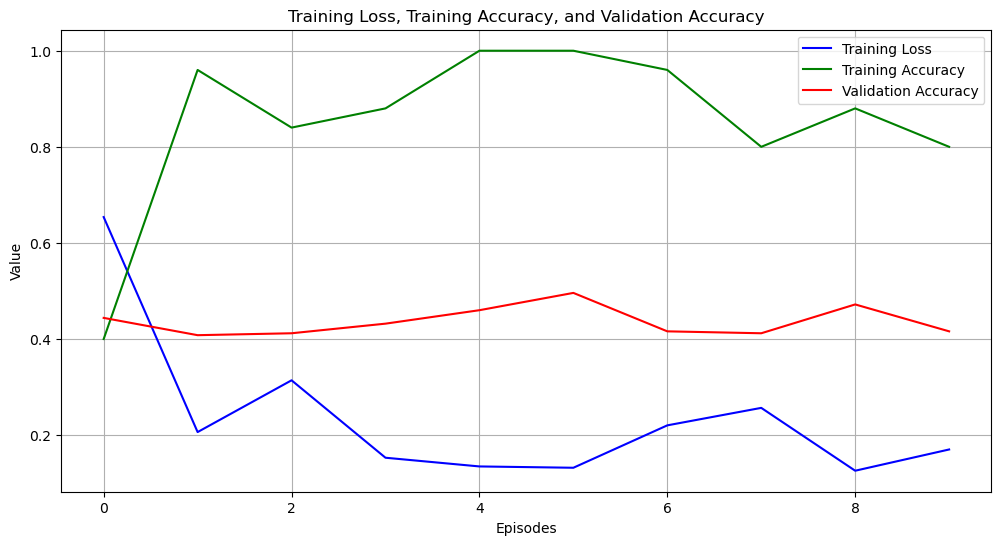

In [18]:
### import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

batch_size = 32
## Training the Prototypical model with episode training
optimizer = torch.optim.Adam(siamese_cnn.parameters(), lr=1e-4, weight_decay=1e-5)
num_episodes = 1000
#num_val_episodes = int(num_episodes/10)
num_val_episodes = 10
n_way = 5
k_shot = 5
q_queries = 5

t2n_nway = n_way

episode_loader = EpisodeLoader(X_train, y, c, n_way, k_shot, q_queries)
val_episode_loader = EpisodeLoader(X_val, y_val, c_val, n_way, k_shot, q_queries)
best_val_accuracy = 0.0
HNM_INTERVAL = 50000 # not use anymore
T2_INTERVAL = 50
best_episode = 0
early_stopping_patience = 20  # Number of evaluations to wait for improvement before stopping

family_list = os.listdir(second_folder)

train_losses = []
train_accuracies = []
val_accuracies = []

with tqdm(total=num_episodes, desc="Training Episodes") as pbar:
    for episode in range(num_episodes):
        # Hard Negative and Hard Positive Mining logic
        if episode % HNM_INTERVAL == 0 and episode != 0:
            with torch.no_grad():
                pair_losses = contrastive_loss(embedding1, embedding2, labels, reduction='none').squeeze()
                loss_percentile = 80

                # Hard Negative Mining
                hard_negative_threshold = torch.quantile(pair_losses[labels == 0], loss_percentile / 100.0)
                hard_negative_condition = (pair_losses > hard_negative_threshold) & (labels == 0)
                hard_negative_indices_tuple = hard_negative_condition.nonzero(as_tuple=True)
                hard_negative_indices = hard_negative_indices_tuple[0]

                # Hard Positive Mining
                hard_positive_threshold = torch.quantile(pair_losses[labels == 1], loss_percentile / 100.0)
                hard_positive_condition = (pair_losses > hard_positive_threshold) & (labels == 1)
                hard_positive_indices_tuple = hard_positive_condition.nonzero(as_tuple=True)
                hard_positive_indices = hard_positive_indices_tuple[0]

                # Selecting and storing actual tensor pairs for hard negatives
                if hard_negative_indices.nelement() > 0:
                    hard_negatives = [
                        (left_imgs[hard_negative_indices].cpu(), right_imgs[hard_negative_indices].cpu())
                    ] if hard_negative_indices.dim() == 0 else [
                        (left_imgs[i].cpu(), right_imgs[i].cpu()) for i in hard_negative_indices
                    ]
                    pbar.write(f"[{episode}] Hard negatives found: {len(hard_negatives)} pairs of {len(pair_losses)} pairs")
                else:
                    hard_negatives = []

                # Selecting and storing actual tensor pairs for hard positives
                if hard_positive_indices.nelement() > 0:
                    hard_positives = [
                        (left_imgs[hard_positive_indices].cpu(), right_imgs[hard_positive_indices].cpu())
                    ] if hard_positive_indices.dim() == 0 else [
                        (left_imgs[i].cpu(), right_imgs[i].cpu()) for i in hard_positive_indices
                    ]
                    pbar.write(f"Hard positives found: {len(hard_positives)} pairs")
                else:
                    hard_positives = []
        else:
            hard_negatives = []
            hard_positives = []

        if episode % T2_INTERVAL == 0 and episode != 0:
            episode_n_way = t2n_nway
            class_accuracy = episode_loader.get_class_accuracy()
            fam_indices = list(remap_dict.values())
            accuracies = np.array([class_accuracy[fam] for fam in fam_indices])
            inverse_accuracies = 1 - accuracies
            if inverse_accuracies.sum() == 0:
                selection_probabilities = None
            else:
                selection_probabilities = inverse_accuracies / inverse_accuracies.sum()

            selected_fam_idx = np.random.choice(fam_indices, p=selection_probabilities)
            selected_fam = f[selected_fam_idx]
            selected_path = os.path.join(second_folder, selected_fam)

            while len(os.listdir(selected_path)) < 2:
                selected_fam_idx = np.random.choice(fam_indices, p=selection_probabilities)
                selected_fam = f[selected_fam_idx]
                selected_path = os.path.join(second_folder, selected_fam)

            episode_n_way = t2n_nway
            if len(os.listdir(selected_path)) < t2n_nway:
                episode_n_way = len(os.listdir(selected_path))
            support_set, support_labels, query_set, query_labels = load_subfamily_data(selected_path, episode_n_way, k_shot, q_queries)
            remap_dict = {}

            for name, param in siamese_cnn.named_parameters():
                if 'encoder' in name:
                    param.requires_grad = False
                else:
                    param.requires_grad = True

            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, siamese_cnn.parameters()), lr=1e-5, weight_decay=1e-5)

        else:
            episode_n_way = n_way
            support_set, support_labels, query_set, query_labels, actual_query_labels, remap_dict = episode_loader.load_episode()

            for param in siamese_cnn.parameters():
                param.requires_grad = True

            optimizer = torch.optim.Adam(siamese_cnn.parameters(), lr=1e-4, weight_decay=1e-5)

        left_imgs, right_imgs, labels = generate_pairs(support_set, k_shot, episode_n_way, device, hard_negatives, hard_positives)

        for i in range(0, left_imgs.size(0), batch_size):
            left_batch = left_imgs[i:i + batch_size]
            right_batch = right_imgs[i:i + batch_size]
            labels_batch = labels[i:i + batch_size]

            optimizer.zero_grad()
            embedding1, embedding2 = siamese_cnn(left_batch, right_batch)
            embedding1 = normalize_embeddings(embedding1)
            embedding2 = normalize_embeddings(embedding2)
            loss = contrastive_loss(embedding1, embedding2, labels_batch)
            loss.backward()
            optimizer.step()

        if episode % 100 == 0:
            siamese_cnn.eval()
            with torch.no_grad():
                accuracy, _, _, _ = evaluate_fewshot_f1(support_set, query_set, k_shot, q_queries, 0.2, episode_n_way, episode_loader, remap_dict)
                train_losses.append(loss.item())
                train_accuracies.append(accuracy)

                val_accuracies_epoch = []
                for _ in range(num_val_episodes):
                    val_support_set, val_support_labels, val_query_set, val_query_labels, actual_query_labels, remap_dict = val_episode_loader.load_episode()
                    val_output, _, _, _ = evaluate_fewshot_f1(val_support_set, val_query_set, k_shot, q_queries, 0.2, episode_n_way, val_episode_loader, remap_dict)
                    val_accuracies_epoch.append(val_output)

                avg_val_accuracy = sum(val_accuracies_epoch) / len(val_accuracies_epoch)
                val_accuracies.append(avg_val_accuracy)
                pbar.write(f"Episode {episode}, Training Loss: {loss.item()}, Training Accuracy: {accuracy}")
                pbar.write(f"Classification Accuracy on Validation ({num_val_episodes} eps): {avg_val_accuracy}")

                if avg_val_accuracy > best_val_accuracy:
                    best_val_accuracy = avg_val_accuracy
                    torch.save(siamese_cnn.state_dict(), 'best_siamese_cbam_'+str(n_way)+'way_sub_aug2.pth')
                    no_improvement_count = 0
                    best_episode = episode
                else:
                    no_improvement_count += 1
                    if no_improvement_count >= early_stopping_patience:
                        pbar.write(f"No improvement for {early_stopping_patience} consecutive evaluations. Stopping training.")
                        break

                siamese_cnn.train()

        pbar.update(1)

print(f"The best model[{best_episode}]: with accuracy of {best_val_accuracy}")

# plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss', color='blue')
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy', color='green')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', color='red')

plt.xlabel('Episodes')
plt.ylabel('Value')
plt.title('Training Loss, Training Accuracy, and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(f"The best model[{best_episode}]: with accuracy of {best_val_accuracy}")

The best model[800]: with accuracy of 0.5199999943375587


In [20]:
# After running some episodes (e.g., during or after training)
class_frequency = episode_loader.get_class_frequency()
print("Class Selection Frequency:", class_frequency)

Class Selection Frequency: {4: 206, 14: 206, 20: 206, 1: 205, 5: 205, 6: 205, 9: 205, 11: 205, 17: 205, 18: 205, 19: 205, 22: 205, 7: 204, 10: 204, 12: 204, 13: 204, 16: 204, 21: 204, 0: 203, 2: 203, 3: 203, 8: 203, 15: 203, 23: 203}


In [21]:
# Assuming you have test data prepared in a similar format to X_train
#test_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\report_117\\extracted_report\\report177_original_img\\test"
#test_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\report_117\\extracted_report\\report177_split4_pixelshuffle4\\test"
#test_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\report_117\\extracted_report\\report177_img2\\test"

test_folder = "test"
#test_folder = "C:\\Users\\USER\\Documents\\VM-shared_177\\mb2023_split1\\test"
n_way = 5
k_shot = 5
q_queries = 5
X_test, y_test, c_test, f_test = loadimgs(test_folder, 256, 256, 1)  # Load test data

[Info] Classes: 5
[Info] Images: 282


In [22]:
# Load the best model
best_model_path = 'best_siamese_cbam_'+str(n_way)+'way_sub_aug2.pth'
siamese_cnn.load_state_dict(torch.load(best_model_path))
siamese_cnn.to(device)
siamese_cnn.eval() 

SiameseCNN(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(128, 128, kernel_siz

In [23]:
def evaluate_run(k_shot):
    num_test_episodes = 100  # or the number of episodes you want to test on
    
    # Initialize metrics
    total_precisions = []
    total_recalls = []
    total_f1s = []
    episode_accuracies = []
    test_episode_loader = EpisodeLoader(X_test, y_test, c_test, n_way, k_shot, q_queries)
    
    for episode in tqdm(range(num_test_episodes)):
        # Load one episode
        support_set, support_labels, query_set, query_labels, actual_query_labels, remap_dict = test_episode_loader.load_episode()
        
        # Forward pass and compute accuracy
        with torch.no_grad():  # No need to track gradients during evaluation
            acc_val, macro_precision, macro_recall, macro_f1 = evaluate_fewshot_f1(support_set, query_set, k_shot, q_queries, 0.2, n_way, test_episode_loader, remap_dict)
            
        episode_accuracies.append(acc_val)
        total_precisions.append(macro_precision)
        total_recalls.append(macro_recall)
        total_f1s.append(macro_f1)
        
    # Calculate various statistics
    average_accuracy = np.mean(episode_accuracies)
    std_dev_accuracy = np.std(episode_accuracies)
    confidence_interval = np.percentile(episode_accuracies, [2.5, 97.5])  # 95% confidence interval
    min_accuracy = np.min(episode_accuracies)
    max_accuracy = np.max(episode_accuracies)
    median_accuracy = np.median(episode_accuracies)
    
    # Calculate averages of metrics
    average_precision = np.mean(total_precisions)
    average_recall = np.mean(total_recalls)
    average_f1 = np.mean(total_f1s)
    
    # Calculate the 95% confidence interval for the mean
    sample_size = len(episode_accuracies)
    confidence_level = 0.95
    alpha = 1 - confidence_level
    z_score = stats.norm.ppf(1 - alpha/2)
    margin_error = z_score * (std_dev_accuracy / np.sqrt(sample_size))
    
    # Display the results
    print(f"Case: {n_way}ways-{k_shot}shots")
    print("Class Selection Frequency:", test_episode_loader.get_class_frequency())
    # Print class-specific accuracy
    class_accuracies = test_episode_loader.get_class_accuracy()
    print("Class Accuracy:", class_accuracies)
    
    print(f"Average Test Accuracy: {average_accuracy:.4f}")
    print(f"Standard Deviation of Test Accuracies: {std_dev_accuracy:.4f}")
    print(f"Margin Error: {margin_error:.4f}")
    print(f"95% Confidence Interval of Test Accuracies: [{confidence_interval[0]:.2f},{confidence_interval[1]:.2f}]")
    print(f"Min Test Accuracy: {min_accuracy:.4f}")
    print(f"Max Test Accuracy: {max_accuracy:.4f}")
    print(f"Median Test Accuracy: {median_accuracy:.4f}")
    print(f"Precision: {average_precision:.4f}")
    print(f"Recall: {average_recall:.4f}")
    print(f"F1-Score: {average_f1:.4f}")
    
    print(f"{average_accuracy:.4f} {std_dev_accuracy:.4f} {margin_error:.4f} {median_accuracy:.4f} {min_accuracy:.4f} {max_accuracy:.4f} [{confidence_interval[0]:.2f},{confidence_interval[1]:.2f}] {average_precision:.4f} {average_recall:.4f} {average_f1:.4f}")

In [24]:
for shot in [5,5]:
    evaluate_run(shot)
    print("###################################")

100%|██████████| 100/100 [06:05<00:00,  3.66s/it]


Case: 5ways-5shots
Class Selection Frequency: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100}
Class Accuracy: {0: 0.276, 1: 0.54, 2: 0.328, 3: 0.326, 4: 0.296}
Average Test Accuracy: 0.3532
Standard Deviation of Test Accuracies: 0.0860
Margin Error: 0.0169
95% Confidence Interval of Test Accuracies: [0.18,0.52]
Min Test Accuracy: 0.1600
Max Test Accuracy: 0.6000
Median Test Accuracy: 0.3600
Precision: 0.3631
Recall: 0.3532
F1-Score: 0.3393
0.3532 0.0860 0.0169 0.3600 0.1600 0.6000 [0.18,0.52] 0.3631 0.3532 0.3393
###################################


100%|██████████| 100/100 [06:41<00:00,  4.02s/it]

Case: 5ways-5shots
Class Selection Frequency: {0: 100, 1: 100, 2: 100, 3: 100, 4: 100}
Class Accuracy: {0: 0.24, 1: 0.594, 2: 0.348, 3: 0.336, 4: 0.326}
Average Test Accuracy: 0.3688
Standard Deviation of Test Accuracies: 0.1035
Margin Error: 0.0203
95% Confidence Interval of Test Accuracies: [0.18,0.56]
Min Test Accuracy: 0.1600
Max Test Accuracy: 0.6400
Median Test Accuracy: 0.3600
Precision: 0.3892
Recall: 0.3688
F1-Score: 0.3574
0.3688 0.1035 0.0203 0.3600 0.1600 0.6400 [0.18,0.56] 0.3892 0.3688 0.3574
###################################
